# <center>  Recommendation System - 4 methods to recommend STEAM games
### <center> Ziyi Lu, Aug-Sep 2019$^*$
     * Lu: Department of  Agricultural and Applied Economics, University of Wisconsing Madison.

<a id = "intro"></a>
## 1. Introduction
<a id = "bkg1"></a>
### 1.1 Task/purpose
### 1.2 Metric
### 1.3 Importing packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import json
import math
import re
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from surprise import Reader, Dataset, SVD, accuracy
from surprise import SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise import model_selection
from surprise.model_selection import train_test_split, cross_validate
import datetime as dt
import sys
!{sys.executable} --version
sys.executable

<a id = "dat"></a>
## 2. Data

**read in app data**

In [2]:
df_raw = pd.read_csv( 'data/app_df.csv' ).drop("Unnamed: 0", axis = 1)
df_raw.head(3)

,name,steam_appid,release_date,currency,price,discount,is_free,required_age,language,recommendations,about_the_game,short_description,genres,windows_support,mac_support,linux_support,metacritic,achievements,url,header_image
0,Counter-Strike,10,"Nov 1, 2000",USD,999.0,0.0,False,0,"English, French, German, Italian, Spanish, Sim...",79848.0,Play the world's number 1 online action game. ...,NaN,['Action'],True,True,True,88.0,0.0,http://steamcommunity.com/app/10,http://cdn.akamai.steamstatic.com/steam/apps/1...
1,Team Fortress Classic,20,"Apr 1, 1999",USD,499.0,0.0,False,0,"English, French, German, Italian, Spanish",2567.0,One of the most popular online action games of...,NaN,['Action'],True,True,True,NaN,0.0,NaN,http://cdn.akamai.steamstatic.com/steam/apps/2...
2,Day of Defeat,30,"May 1, 2003",USD,499.0,0.0,False,0,"English, French, German, Italian, Spanish",2519.0,Enlist in an intense brand of Axis vs. Allied ...,NaN,['Action'],True,True,True,79.0,0.0,NaN,http://cdn.akamai.steamstatic.com/steam/apps/3...


**read in user data**

In [3]:
user_df = pd.read_csv( r'data\user_df_clean.csv')
user_df = user_df.drop( 'Unnamed: 0' , axis = 1 )
user_df.head()

,user_id,appid,playtime_forever
0,76561198074188133,4000,3415
1,76561198074188133,34030,16526
2,76561198074188133,42680,4631
3,76561198074188133,42690,11055
4,76561198074188133,207610,126


<a id = "bkg2"></a>
### 2.1 Feature extraction and Exploratory Data Analysis

**price distribution:**

In [19]:
# convert price variable to float

df_raw.price.iloc[ np.where(df_raw.price.values == 'True')[0].tolist() ] = float("nan")

df_raw.price.iloc[ np.where(df_raw.price.values == 'False' )[0].tolist() ] = float("nan")

df_raw.price = df_raw.price.astype(float)

C:\Users\luziy\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\luziy\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\luziy\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  """


In [5]:
# encode is_free

df_raw.is_free = np.where(df_raw.is_free == "True", 1, 0 )  # 0: not free; 1: free

pd.Series(df_raw.is_free).value_counts()

0    12152
1     1000
Name: is_free, dtype: int64

**release time distribution**

In [18]:
# convert time variable to date.time 
release_date = np.array( df_raw.release_date.values.tolist() )
df_raw.release_date = pd.to_datetime( release_date, errors = 'coerce' )   # all errors would be ignored and converted to nan

**required age**

In [ ]:
# encode required_age

# if length is more than 3, turn to nan

ord_noage = np.where(pd.Series(map(  lambda x: len(x) if isinstance(x, float) == False else x,  df_raw.required_age )) > 2 )[0].tolist()
df_raw.required_age.iloc[ord_noage] = float("nan")

df_raw.required_age = df_raw.required_age.astype("float")

df_raw.required_age.value_counts()   # get rid of outliers 

**System support**

In [8]:
df_raw.windows_support = np.where( df_raw.windows_support == True, 1, 0)
pd.Series(df_raw.windows_support).value_counts()   # almost all games have windows support. Drop this variable

df_raw.mac_support = np.where( df_raw.mac_support == True, 1, 0)
pd.Series(df_raw.mac_support).value_counts()  # 

df_raw.linux_support= np.where( df_raw.linux_support == True, 1, 0)
pd.Series(df_raw.linux_support).value_counts()  # 

0    10120
1     3032
Name: linux_support, dtype: int64

**language support**

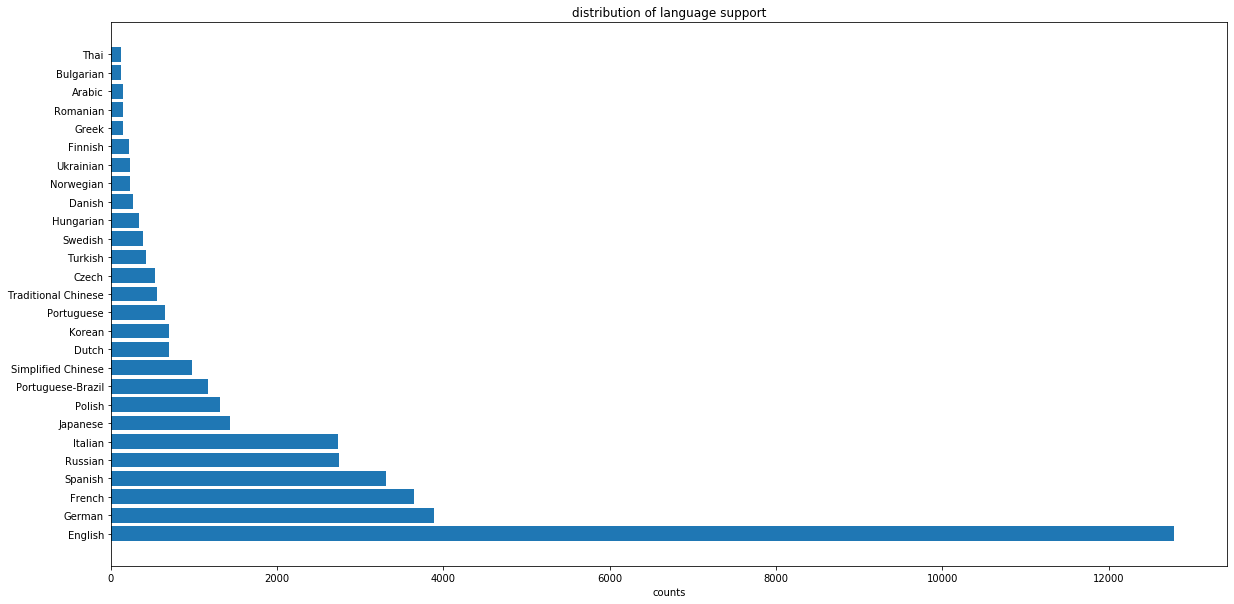

In [58]:
# encode language 

def game_lang(a):
    if isinstance(a, float)  == False:
        a1 = a.replace("<strong>*</strong>", "").replace("<br>", "").replace("languages with full audio support", "" )
        return(a1)
    else:
        return(a)

lang_clean = [ game_lang(i)  for i in df_raw.language.values ]

# lang_clean[13129]

lang_store = []
for i in lang_clean:
    if isinstance(i, float)  == False:
        lst_break = i.split(", ")
        lang_store += lst_break

lang_counts = pd.Series(lang_store).value_counts()

# lang_counts 
plt.figure(figsize=(20,10))
plt.barh( lang_counts.index[0:27], lang_counts.values[0:27])
plt.xlabel('counts')
plt.title('distribution of language support')

lang_df = pd.DataFrame(np.array( [ list(map(lambda x: "English" in x if isinstance(x, float)  == False else x, lang_clean)), 
  list(map(lambda x: "German" in x if isinstance(x, float)  == False else x, lang_clean)) ,
  list(map(lambda x: "French" in x if isinstance(x, float)  == False else x, lang_clean)) ,
   list(map(lambda x: "Spanish" in x if isinstance(x, float)  == False else x, lang_clean)) ,
   list(map(lambda x: "Russian" in x if isinstance(x, float)  == False else x, lang_clean))  ,
   list(map(lambda x: "Italian" in x if isinstance(x, float)  == False else x, lang_clean)) ]        ).transpose() ,
                      columns = ["English", "German", "French", "Spanish" , "Russian", "Italian" ])

**game genres distribution**

Text(0.5, 0, 'counts')

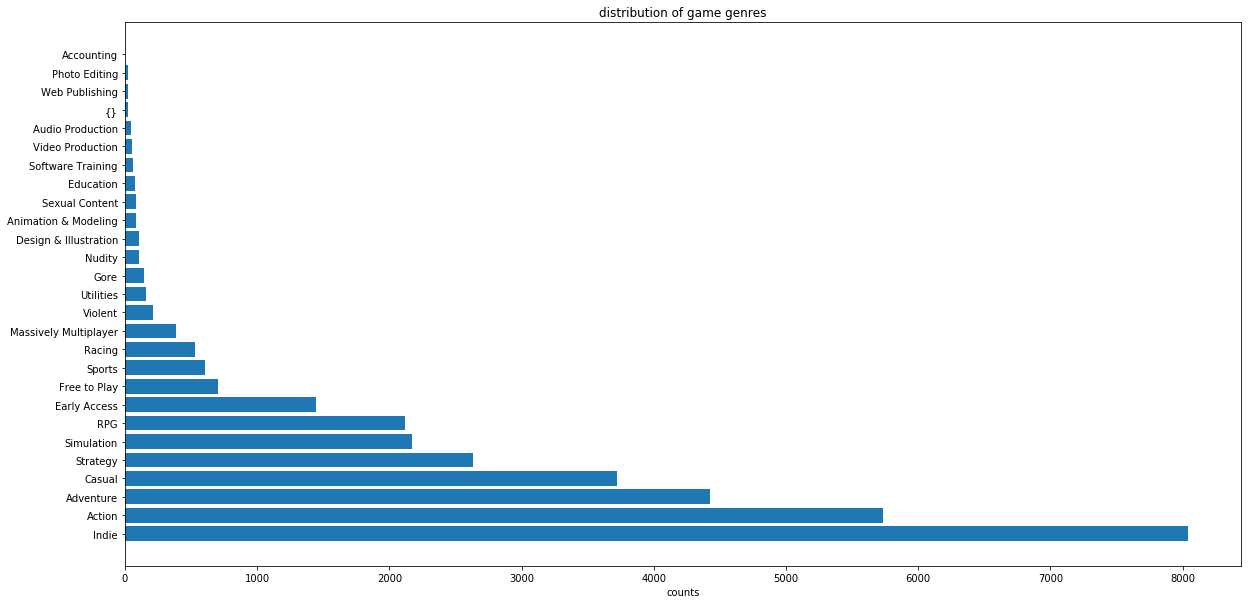

In [28]:

def genres_lang(a):
    if isinstance(a, float)  == False:
        a1 = a.replace("'", "").replace("[", "").replace("]", "" )
        return(a1)
    else:
        return(a)

genres_clean = [ genres_lang(a) for a in df_raw.genres.values ]

genres_store = []
for i in genres_clean:
    if isinstance(i, float)  == False:
        lst_break = i.split(", ")
        genres_store += lst_break

genres_counts = pd.Series(genres_store).value_counts()

plt.figure(figsize=(20,10))
plt.barh( genres_counts.index[0:27], genres_counts.values[0:27])
plt.title('distribution of game genres')
plt.xlabel('counts')

In [29]:
genres_df = pd.DataFrame(np.array( [ list(map(lambda x: "Indie" in x if isinstance(x, float)  == False else x, genres_clean)), 
  list(map(lambda x: "Action" in x if isinstance(x, float)  == False else x, genres_clean)) ,
  list(map(lambda x: "Adventure" in x if isinstance(x, float)  == False else x, genres_clean)) ,
   list(map(lambda x: "Casual" in x if isinstance(x, float)  == False else x, genres_clean)) ,
   list(map(lambda x: "Strategy" in x if isinstance(x, float)  == False else x, genres_clean))  ,
   list(map(lambda x: "Simulation" in x if isinstance(x, float)  == False else x, genres_clean))  ,
   list(map(lambda x: "RPG" in x if isinstance(x, float)  == False else x, genres_clean)) ,
   list(map(lambda x: "Early Access" in x if isinstance(x, float)  == False else x, genres_clean))      ]        ).transpose() ,
                      columns = ["Indie", "Action", "Adventure", "Casual" , "Strategy", "Simulation", "RPG","Early Access" ])

**merge cleaned user and app dataset**

In [30]:
# # # final app dataframe
app_df = pd.concat( [df_raw,lang_df ] , axis = 1)

app_df = pd.concat( [app_df , genres_df ] , axis = 1)

# app_df.to_csv( r'data\app_df_clean.csv' , header = True )

app_df.dtypes  

name                         object
steam_appid                  object
release_date         datetime64[ns]
currency                     object
price                       float64
discount                    float64
is_free                      object
required_age                float64
language                     object
recommendations             float64
about_the_game               object
short_description            object
genres                       object
windows_support              object
mac_support                  object
linux_support                object
metacritic                  float64
achievements                float64
url                          object
header_image                 object
English                     float64
German                      float64
French                      float64
Spanish                     float64
Russian                     float64
Italian                     float64
Indie                       float64
Action                      

In [31]:
user_df.loc[:, "appid" ]  = user_df.appid.astype("str")
user_df.loc[:, "user_id" ]  = user_df.user_id.astype("str")
common_element = [(user_df.appid.values[i] in app_df.steam_appid.values) for i in range(0, user_df.shape[0])]
print("there are", len(np.unique(user_df.appid)), "unique games")
print(sum(common_element) , "in user_df out of" , user_df.shape[0], "are found" )

there are 10138 unique games
69525 in user_df out of 88489 are found


In [32]:
# In the user dataframe, only keep apps existing in app dataframe 
user_df = user_df.loc[ common_element , : ]
user_df.shape

(69525, 3)

In [33]:
# combine user data with app information
df = user_df.merge( app_df, how = 'left', left_on = "appid", right_on = "steam_appid" )
df.head(3)

,user_id,appid,playtime_forever,name,steam_appid,release_date,currency,price,discount,is_free,...,Russian,Italian,Indie,Action,Adventure,Casual,Strategy,Simulation,RPG,Early Access
0,76561198074188133,4000,3415,Garry's Mod,4000,2006-11-29,USD,999.0,0.0,False,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,76561198074188133,34030,16526,Napoleon: Total War™,34030,2010-02-23,USD,1999.0,0.0,False,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,76561198074188133,42680,4631,Call of Duty®: Modern Warfare® 3,42680,2011-11-08,USD,3999.0,0.0,False,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


**gamed played by users**

In [34]:

df = df.loc[ df.playtime_forever != 0 , : ]      # many games are not played
df.shape

(41756, 37)

Text(0.5, 1.0, 'play time distribution -- zoom in')

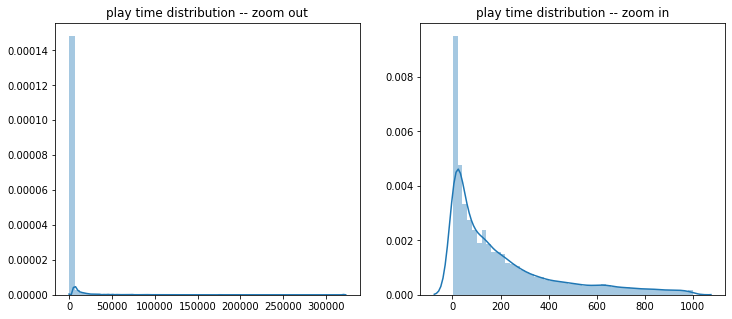

In [53]:
playtime = df.playtime_forever.values

f, axes = plt.subplots(1, 2, figsize = (12,5))
axes_ = axes.ravel()
sns.distplot(playtime, ax=axes_[0] ).set_title("play time distribution -- zoom out")
sns.distplot(playtime[playtime < 1000], ax=axes_[1]).set_title("play time distribution -- zoom in")

**label extraction**

In [20]:
# should count na here and come to the conclusion that recommendations should be used as label
df.loc[ : , ['recommendations', 'metacritic', 'achievements'] ].head(10)

,recommendations,metacritic,achievements
0,259813.0,NaN,29.0
1,6353.0,81.0,71.0
2,20455.0,NaN,76.0
3,31796.0,82.0,48.0
4,21664.0,76.0,50.0
5,28308.0,NaN,251.0
6,79534.0,79.0,41.0
7,25474.0,NaN,60.0
8,6430.0,NaN,96.0
9,9583.0,NaN,412.0


In [21]:
df.loc[ : , ['recommendations', 'metacritic'] ].corr()   

,recommendations,metacritic
recommendations,1.000000,0.125707
metacritic,0.125707,1.000000


In [56]:
recommend_score = df.recommendations[ ~np.isnan(df.recommendations)]

Text(0.5, 1.0, 'recommendation score distribution -- zoom in')

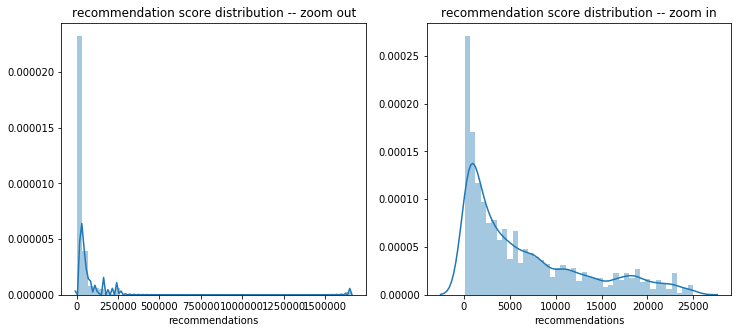

In [57]:

f, axes = plt.subplots(1, 2, figsize = (12,5))
axes_ = axes.ravel()
sns.distplot(recommend_score, ax=axes_[0] ).set_title("recommendation score distribution -- zoom out")
sns.distplot(recommend_score[recommend_score < 25000], ax=axes_[1]).set_title("recommendation score distribution -- zoom in")

In [23]:
# how much the user likes a game:
# 同一个游戏比
playtime_qt = np.quantile(df.playtime_forever, q = [0.2, 0.4, 0.6, 0.8])

df.loc[ df.playtime_forever <= playtime_qt[0] , "liking"] = 1
df.loc[ (df.playtime_forever > playtime_qt[0]) & (df.playtime_forever <= playtime_qt[1]) , "liking"] = 2
df.loc[ (df.playtime_forever > playtime_qt[1]) & (df.playtime_forever <= playtime_qt[2]) , "liking"] = 3
df.loc[ (df.playtime_forever > playtime_qt[2]) & (df.playtime_forever <= playtime_qt[3]) , "liking"] = 4
df.loc[ df.playtime_forever > playtime_qt[3] , "liking"] = 5

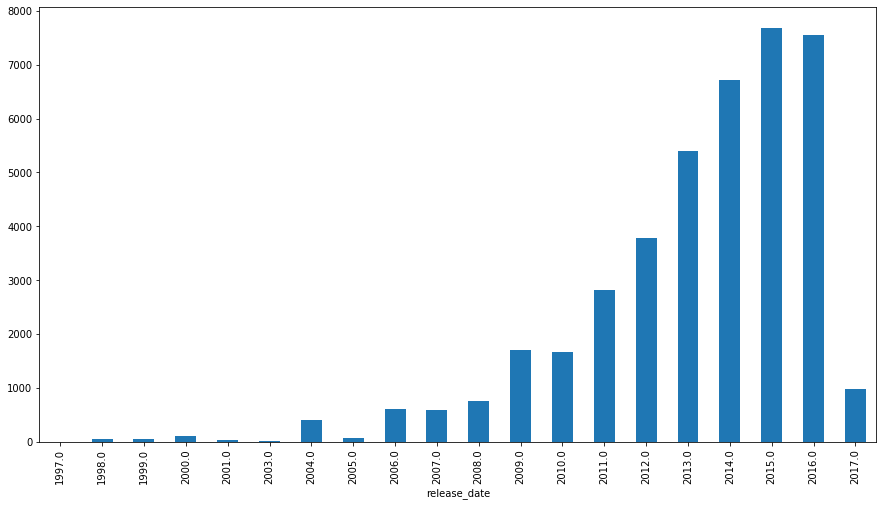

In [24]:
release_date = np.array( df.release_date.values.tolist() )
df.loc[ :, "release_date"] = pd.to_datetime( df.release_date, errors = 'coerce' )   # all errors would be ignored and converted to nan

plt.rcParams['figure.figsize'] = [15, 8]
df.release_date.groupby(df.release_date.dt.year).count().plot(kind="bar")

In [25]:
print( "there are", len(np.unique(df.user_id)), "users in the dataset", "and", len(np.unique(df.loc[df.release_date.dt.year >= 2016, "user_id"])),
     "of them have games after 2017")    

there are 314 users in the dataset and 310 of them have games after 2017


<a id = "bkg2"></a>
### 3. Modeling

I make recommendations based on the user's favourate/most played movie. User's favourate movies are: 

In [26]:
most_played = user_df.groupby( ['user_id'], sort = False )[ ['user_id', 'appid' ,'playtime_forever'] ].max()
most_played.head()

,user_id,appid,playtime_forever
user_id,,,
76561198074188133,76561198074188133,8930,32116
76561198058088990,76561198058088990,96100,41260
76561198042649112,76561198042649112,99410,121162
76561198094755500,76561198094755500,8190,82806
76561198129813597,76561198129813597,96000,35641


### 3.1 Model 1: Simple Recommender based on popularity

**table of the top 10 popular games in general and by genres:**

In [27]:
genres_lst = ['Indie', 'Action', 'Adventure', 'Casual', 'Strategy', 'Simulation', 'RPG', 'Early Access']

pop_table = pd.DataFrame()

pop_table.loc[ : , "overall" ] = app_df.loc[ : , [ 'recommendations', 'name'] ].sort_values( 'recommendations', ascending = False ).iloc[0:10 ,:].name.values

for i in genres_lst[0:5]:
    pop_table.loc[ : , i ] = app_df.loc[ app_df.loc[ :, i] == 1 , [ 'recommendations', 'name'] ].sort_values( 'recommendations', ascending = False ).iloc[0:10 ,:].name.values
    
pop_table

,overall,Indie,Action,Adventure,Casual,Strategy
0,Counter-Strike: Global Offensive,Garry's Mod,Counter-Strike: Global Offensive,Unturned,Unturned,Dota 2
1,Dota 2,Unturned,Dota 2,Grand Theft Auto V,Starbound,Sid Meier's Civilization® V
2,Team Fortress 2,Terraria,Team Fortress 2,Terraria,Goat Simulator,Arma 3
3,Garry's Mod,Rust,PAYDAY 2,Rust,Trove,Space Engineers
4,PAYDAY 2,DayZ,Unturned,ARK: Survival Evolved,Clicker Heroes,Insurgency
5,Unturned,Rocket League®,Grand Theft Auto V,Portal 2,Castle Crashers®,Clicker Heroes
6,The Elder Scrolls V: Skyrim,ARK: Survival Evolved,Terraria,No Man's Sky,BattleBlock Theater®,Cities: Skylines
7,Grand Theft Auto V,Euro Truck Simulator 2,Rust,Life Is Strange - Episode 1,AdVenture Capitalist,FTL: Faster Than Light
8,Terraria,Robocraft,Left 4 Dead 2,H1Z1 : Just Survive,Emily is Away,XCOM: Enemy Unknown
9,Rust,Undertale,DayZ,Starbound,Counter-Strike Nexon: Zombies,Age of Empires II HD


### 3.2: Content Based Recommender
The recommender we built in the previous section suffers some severe limitations. For one, it gives the same recommendation to everyone, regardless of the user's personal taste. 


In [28]:
# replace nan with ''
app_df['about_the_game'] = app_df['about_the_game'].fillna('')

app_df.about_the_game.values[1]

app_df['about_the_game'] = [" ".join( re.sub("\<.*?\>", "", x).split())  for x in app_df.about_the_game.values ]

In [29]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')

tfidf_matrix = tf.fit_transform(app_df['about_the_game'])

tfidf_matrix.shape

(13152, 1118410)

In [30]:
# I will be using the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two gams. 
# Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's linear_kernel instead of cosine_similarities since it is much faster.
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# content based recommender provides cold start for 2017 games 

app_release_date = pd.to_datetime( app_df.release_date, errors = 'coerce' )   # all errors would be ignored and converted to nan
app_release_date = pd.DataFrame(app_release_date)

app_release_date.columns = ["date"]

game_new = app_df.loc[ app_release_date["date"].dt.year >= 2017, : ]

new_games = game_new.steam_appid.values.tolist()

id = app_df.steam_appid.values.tolist()

most_played_games = set(most_played.appid.values.tolist())
most_played_games = list(most_played_games)
most_played_game_order = [id.index(most_played_games[i]) for i in range(len(most_played_games)) ] 

new_games = game_new.steam_appid.values.tolist()
new_games_order = [id.index(new_games[i]) for i in range(len(new_games)) ]

rec_table = []

for i in most_played_game_order:
  lst = cosine_sim[i].tolist()
  rec = np.array(id)[ [ lst.index(i) for i in np.sort( np.array(lst)[new_games_order] )[::-1][1:6]   ]]  # error 
  rec_table.append(rec)

rec_df = pd.DataFrame(rec_table)

rec_df.columns = [ "rec1", "rec2", "rec3", "rec4" , "rec5" ]

rec_df.loc[:,"appid"] = most_played_games

rec_df = rec_df[["appid",  "rec1", "rec2", "rec3", "rec4" , "rec5"]]

rec_df.head()

,appid,rec1,rec2,rec3,rec4,rec5
0,9340,312660,586040,311290,588890,388960
1,92100,575840,464950,405340,520080,421020
2,730,502280,541240,521680,575400,576400
3,9940,552000,431650,560730,367080,386770
4,96000,575990,417020,577850,381890,563150


### 3.3: collaborative filtering
Our content based engine suffers from some severe limitations. It is only capable of suggesting games which are close to a certain game. That is, it is not capable of capturing tastes and providing recommendations across genres.

I will use the Surprise library that used extremely powerful algorithms like Singular Value Decomposition (SVD) to minimise RMSE (Root Mean Square Error) and give great recommendations.

In [31]:
reader = Reader()
df_ = Dataset.load_from_df( df[[ 'user_id', 'appid', 'liking'   ]] , reader)

df_tr, df_t = train_test_split(df_, test_size = 0.25)

benchmark = []

# Iterate over all algorithms

for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:

    # Perform cross validation

    results = cross_validate(algorithm, df_, measures=['RMSE'], cv=3, verbose=False)

    

    # Get results & append algorithm name

    tmp = pd.DataFrame.from_dict(results).mean(axis=0)

    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))

    benchmark.append(tmp)

    

pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')  

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,1.188162,0.071483,0.100720
SVDpp,1.198628,71.024203,2.558320
KNNBaseline,1.200034,0.113029,1.394607
SVD,1.201311,1.740671,0.117019
KNNWithZScore,1.224650,0.082768,1.254313
SlopeOne,1.228307,0.767990,1.951965
KNNWithMeans,1.230146,0.064549,1.167223
KNNBasic,1.241363,0.056515,1.009633
CoClustering,1.249858,1.125980,0.083444


In [32]:
# choose SVD train on a whole trainset before 2017
game_old = df.loc[ df.release_date.dt.year < 2017, : ]

game_old_data = Dataset.load_from_df( game_old[[ 'user_id', 'appid', 'liking'   ]] , reader) 

trainset = game_old_data.build_full_trainset()


algo = SVD()

algo.fit(trainset)

In [33]:
# take user id "76561198072330395" as an example for prediction of liking: 
algo.predict( uid = "76561198072330395" , iid = "4000" ).est

3.813536706809514

### 3.4: hybrid recommender
- based on the user's favorate/most played game: 
- use collaborative filtering to recommend well established games released before 2017. the testing set can be all the old games (within certain ranking of the same grene) that haven't been tried by the user
- use content based methods to recommend new games released after 2017.

In [34]:
pop_ranking = app_df.loc[ : , ([ 'recommendations', 'name', "steam_appid"] + genres_lst )].sort_values( 'recommendations', ascending = False )
pop_ranking.loc[:, "general_ranking"] = range(1, (len(pop_ranking.recommendations)+1) )
pop_ranking.head()

,recommendations,name,steam_appid,Indie,Action,Adventure,Casual,Strategy,Simulation,RPG,Early Access,general_ranking
25,1655597.0,Counter-Strike: Global Offensive,730,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
22,665563.0,Dota 2,570,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2
19,410456.0,Team Fortress 2,440,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3
141,259813.0,Garry's Mod,4000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4
1695,239595.0,PAYDAY 2,218620,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5


In [35]:
# create a dataframe *** 
recommend_df = pd.DataFrame()

for user in most_played.user_id:
    favourate = most_played.loc[most_played.user_id == user , "appid"  ].values[0]

    fav_info = app_df.loc[ app_df.steam_appid == favourate ,  genres_lst    ]
    
    if (fav_info.sum(axis = 1) == 0).values[0]:   # if genre can be found
        continue
    else:
        try:
          fav_genre = fav_info.columns[np.array(fav_info)[0] == 1].values
        except IndexError:
            continue

        cond_lst = ['name' , 'name', 'name' , 'name', 'name' , 'name', 'name'  ]

        cond_lst[ 0: len(fav_genre) ] = fav_genre
 
        recommend_scope = pd.DataFrame({"user_id" : [user] * 10})

        recommend_scope.loc[:, "new_app_id"] = pop_ranking.loc[ (pop_ranking[cond_lst[0]] == 1)|(pop_ranking[cond_lst[1]] == 1)|(pop_ranking[cond_lst[2]] == 1)|(pop_ranking[cond_lst[3]] == 1)|(pop_ranking[cond_lst[4]] == 1)|(pop_ranking[cond_lst[5]] == 1)|(pop_ranking[cond_lst[6]] == 1)  , "steam_appid" ].values[0:10] 
 
        recommend_scope.loc[:, "is_2017"] = [ recommend_scope.new_app_id[i] in df.loc[(df.user_id == "76561198074188133") & (df.release_date.dt.year == 2017), "appid"].values for i in range(10)]

        recommend_df = pd.concat( [recommend_df, recommend_scope], axis = 0 )

est = [algo.predict( uid = recommend_df.user_id.values[i] , iid = recommend_df.new_app_id.values[i] ).est for i in range(recommend_df.shape[0])]

recommend_df.loc[ :, "est"] = est

In [36]:
# combine all information and make final display table
recommend_df = recommend_df.sort_values( [ "user_id" ,"est"], ascending = False ).groupby("user_id").head(4)

most_played.index.name = None

recommend_df = recommend_df.merge(most_played, on = "user_id" )

recommend_df = recommend_df.drop(["est", "playtime_forever", "is_2017"  ],axis = 1  )

recommend_df_new = recommend_df.loc[: , ["user_id", "appid"  ] ].drop_duplicates()

recommend_df_new = recommend_df_new.merge(rec_df[["appid" , "rec1" ] ].drop_duplicates(), how = "left" , on = "appid")

recommend_df_new = recommend_df_new.rename( columns = {"rec1": "new_app_id"} )

recommend_df = recommend_df[ recommend_df_new.columns ]

recommend_df = pd.concat( [recommend_df, recommend_df_new], axis = 0, sort=True )

recommend_df = recommend_df[ [ "user_id", "appid" , "new_app_id" ] ] 
recommend_df = recommend_df.sort_values( 'user_id')

merge_info = app_df[ ["steam_appid", "name", "release_date"  ] ].drop_duplicates()

recommend_df = recommend_df.merge(merge_info, how = "left", left_on = "appid" , right_on = "steam_appid" ).drop("steam_appid", axis = 1)

recommend_df = recommend_df.rename( columns = { "appid": "favourate_game_id" , "name": "favourate_game_name", "release_date": "favourate_movie_release_date" } )  

recommend_df = recommend_df.merge(merge_info, left_on = "new_app_id", right_on = "steam_appid", how = "left").drop("steam_appid", axis = 1)
recommend_df = recommend_df.sort_values( "user_id"  )

recommend_df = recommend_df.rename( columns = { "new_app_id": "recommend_app_id" , "name": "recommend_game_name", "release_date": "recommemd_movie_release_date" } )  

recommend_df = recommend_df[[  "user_id", "favourate_game_id", "favourate_game_name", "favourate_movie_release_date", "recommend_app_id", "recommend_game_name", "recommemd_movie_release_date"  ] ]

**The final display table for each user's top 5 game recommendations is:**

In [37]:
recommend_df.head(20)

,user_id,favourate_game_id,favourate_game_name,favourate_movie_release_date,recommend_app_id,recommend_game_name,recommemd_movie_release_date
0,76561197960422789,98200,Frozen Synapse,2011-05-26,567890,Zero-G,2017-01-13
1,76561197960422789,98200,Frozen Synapse,2011-05-26,8930,Sid Meier's Civilization® V,2010-09-21
2,76561197960422789,98200,Frozen Synapse,2011-05-26,252950,Rocket League®,2015-07-07
3,76561197960422789,98200,Frozen Synapse,2011-05-26,221100,DayZ,2013-12-16
4,76561197960422789,98200,Frozen Synapse,2011-05-26,252490,Rust,2013-12-11
5,76561197961921277,9900,Star Trek Online,2012-01-31,218620,PAYDAY 2,2013-08-13
6,76561197961921277,9900,Star Trek Online,2012-01-31,252490,Rust,2013-12-11
7,76561197961921277,9900,Star Trek Online,2012-01-31,346110,ARK: Survival Evolved,2015-06-02
8,76561197961921277,9900,Star Trek Online,2012-01-31,105600,Terraria,2011-05-16
9,76561197961921277,9900,Star Trek Online,2012-01-31,592340,Mall Empire,2017-02-16


## References

get back to feature selection: https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e\

imbalanced dataset/classification: https://www.analyticsvidhya.com/blog/2017/03/imbalanced-classification-problem/



Very theoretical: 
https://medium.com/recombee-blog/machine-learning-for-recommender-systems-part-1-algorithms-evaluation-and-cold-start-6f696683d0ed

Good explanations: 
https://towardsdatascience.com/recommender-systems-in-practice-cef9033bb23a

a example of movie recommendations:

https://www.kaggle.com/rounakbanik/the-story-of-film/

https://www.kaggle.com/rounakbanik/movie-recommender-systems

**content-based:**
 - based on similarity of item attributes

**collaborative filtering:**
- calculate similarity from interactions
- Nearest neighbor: user based / item based
- SVD from Surprise
- Matrix factorization: important

https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b

http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/

ALS:
https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1
https://github.com/KevinLiao159/MyDataSciencePortfolio/blob/master/movie_recommender/movie_recommendation_using_ALS.ipynb
https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe

**ensembling/a combination of the two**

https://medium.com/recombee-blog/machine-learning-for-recommender-systems-part-1-algorithms-evaluation-and-cold-start-6f696683d0ed